In [ ]:
# default_exp blocks.trend

In [ ]:
# export
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.Tensor.ndim = property(lambda x: x.dim())

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Trend
> Linear trend of time series.

In [ ]:
# export
class Trend(nn.Module):
    """
    Broken Trend model, with breakpoints as defined by user.
    parameters:
    - breakpoints (optional): number of breaks in trend
    - date_range: Required if breakpoints is given. Start and stop date in days.
    - mean: mean of time
    - scale: standard deviation of time
    """
    def __init__(self, breakpoints:int=None, date_range=None, mean=0, scale=1):
        super().__init__()
        self.init_layer = nn.Linear(1,1) # first linear bit
            
        if breakpoints is not None:
            if isinstance(breakpoints, int):
                if breakpoints > 0:
                    breakpoints = np.linspace(*date_range, breakpoints+1, endpoint=False)[1:]
                else:
                    breakpoints = None
            # create deltas which is how the gradient will change
            deltas = torch.zeros(len(breakpoints)) # initialisation
            self.deltas = nn.Parameter(deltas) # make it a parameter
                
            self.bpoints = (breakpoints -  mean) / scale
        else:
            self.bpoints = None
        
    def __copy2array(self):
        """
        Saves parameters into wb
        """
        # extract gradient and bias
        w = self.init_layer.weight
        b = self.init_layer.bias
        self.params = [[w,b]] # save it to buffer
        if self.bpoints is not None:
            for d, x1 in zip(self.deltas, self.bpoints):
                y1 = w *x1 + b # find the endpoint of line segment (x1, y1)
                w = w + d # add on the delta to gradient 
                b = y1 - w * x1 # find new bias of line segment 
                self.params.append([w,b]) # add to buffer

        # create buffer
        self.wb = torch.zeros(len(self.params), len(self.params[0]))
        for i in range(self.wb.shape[0]):
            for j in range(self.wb.shape[1]):
                self.wb[i,j] = self.params[i][j]
        
    def forward(self, t:torch.Tensor):
        if self.bpoints is not None:
            self.__copy2array() # copy across parameters into matrix
            # get the line segment area (x_sec) for each x
            x_sec = t >= self.bpoints
            x_sec = x_sec.sum(1)
            
            # get final prediction y = mx +b for relevant section
            return t*self.wb[x_sec][:,:1] + self.wb[x_sec][:,1:]
        
        else:
            return self.init_layer(t)

# Test with Dummy Data

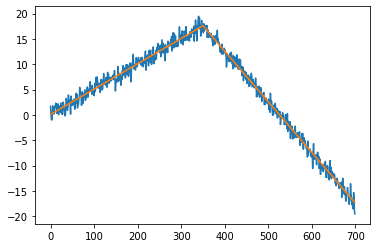

In [ ]:
N = 700
t = np.arange(N)

trend = 0.05*t + 0.1
trend[t>350] = -0.1*(t[t>350] - 350) + trend[t==350]

noise = np.random.randn(*trend.shape)
y = trend + noise
# y = np.clip(y, 1, 20)

plt.plot(t, y)
plt.plot(t, trend)
plt.show()

In [ ]:
# hide
from fastai.data_block import DataBunch, DatasetType
from fastai.basics import Learner
from profetorch.data import TimeSeries

train_len = int(0.8*len(y))
train_ds = TimeSeries(t[:train_len], y[:train_len])
test_ds = TimeSeries(t[train_len:], y[train_len:])
bs = 96
db = DataBunch.create(train_ds, test_ds, bs=bs)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


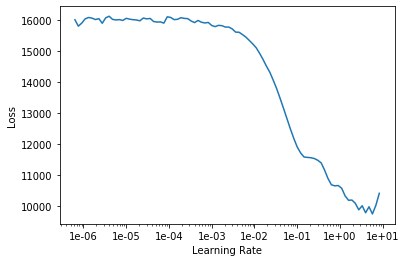

In [ ]:
breakpoints = torch.Tensor([250, 500])
model = Trend(breakpoints)
learner = Learner(db, model, loss_func=F.mse_loss)
wd = 0
learner.lr_find(wd=wd)
learner.recorder.plot(skip_end=0)

In [ ]:
epochs = 10
learner.fit_one_cycle(epochs, 1e-1, wd=wd)

epoch,train_loss,valid_loss,time
0,15006.965820,48516.570312,00:00
1,10705.563477,993.336182,00:00
2,7057.067871,29231.976562,00:00
3,5744.917969,11459.618164,00:00
4,4433.373047,556.789673,00:00
5,3629.159668,733.305664,00:00
6,2988.094727,189.605576,00:00
7,2479.688965,1147.893921,00:00
8,2095.290527,1420.154663,00:00
9,1794.216064,1420.845947,00:00


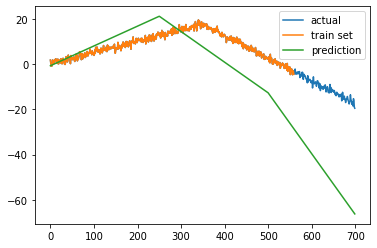

In [ ]:
y2 = learner.model(torch.Tensor(t)[:,None])
plt.plot(t, y, label='actual')
plt.plot(t[:train_len], y[:train_len], label='train set')
plt.plot(t, y2, label='prediction')
plt.legend()
plt.show()

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 99_index.ipynb.
Converted Fourier.ipynb.
Converted Holidays.ipynb.
Converted LinearX.ipynb.
Converted Squasher.ipynb.
Converted Trend.ipynb.
Converted blocks.ipynb.
Converted callbacks.ipynb.
Converted data.ipynb.
Converted losses.ipynb.
Converted model.ipynb.
